# Planar data classification with one hidden layer

It's time to build your first neural network with one single hidden layer. You will notice a big difference between this model and the logistic regression model you implemented in ENG4200.

By the end of this Jupyter Notebook, you will be able to:
- Implement a binary classification neural network with a single hidden layer
- Use units with a nonlinear activation function, such as $\mathrm{tanh}$
- Compute the cross entropy loss
- Implement forward propagation and backward propagation from scratch

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

np.set_printoptions(precision=8)

## <font color='magenta'>Data generation</font>

In this notebook, we shall generate data that looks like a *flower* with two classes, $y = 0$ or $y=1$. Using the colormap *Spectral*, we can visualize data points with label $y =0$ by red and $y = 1$ by blue. Our goal is to build a model to fit this dataset. In otherwords, we aim to build a classifier to define regions as either red or blue.

In [2]:
def load_planar_dataset(m=400):
    np.random.seed(42)
    X = np.zeros(shape=(m, 2))
    y = np.zeros(m, dtype=np.uint16)
    a = 4
    N = int(m//2)
    D = 2
    for j in range(2):
        idx = range(N*j, N*(j + 1))
        theta = np.linspace(3.12 * j, 3.12*(j + 1), N) + np.random.randn(N) * 0.2
        r = a * np.sin(4 * theta) + np.random.randn(N)*0.2
        X[idx] = np.c_[r*np.sin(theta), r*np.cos(theta)]
        y[idx] = j

    return X, y

We will need the following to the decision boundaries later. Don't worry about this at this point. Just move on!

In [3]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, y_min = X.min(axis=0) - 1
    x_max, y_max = X.max(axis=0) + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

In [4]:
X, y = load_planar_dataset()

print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

X.shape = (400, 2)
y.shape = (400,)


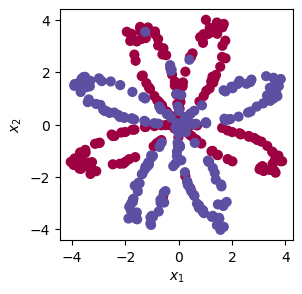

In [5]:
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## <font color='magenta'>Simple Logistic Regression</font>

Before building a full neural network, let's check how logistic regression performs on this problem. We can use sklearn's built-in functions for this. We have learned how to build and train a logistic regression classifier on a dataset from ENG4200. There is no need for lengthy explanation here. As we will see, the accuracy is terrible. This is not a surprising as the dataset cannot be linearly separated by a linear line. The figure explains itself, so we need no further explanation.

Accuracy of logistic regression: 49.75 %


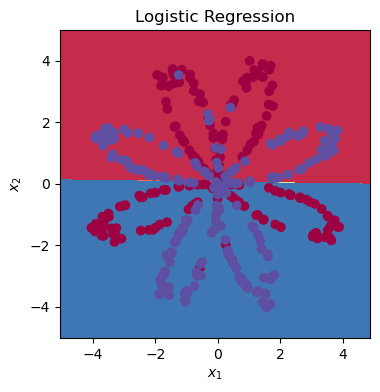

In [6]:
# Plot the decision boundary for logistic regression
lr = LogisticRegression()
lr.fit(X, y)
plt.figure(figsize=(4, 4))
plot_decision_boundary(lambda x: lr.predict(x), X, y)
plt.title("Logistic Regression")

# Print accuracy
y_pred = lr.predict(X)
print (f"Accuracy of logistic regression: {float((np.dot(y, y_pred) + np.dot(1-y,1-y_pred))/float(y.size)*100)} %")

## <font color='magenta'>Neural network model</font>

Logistic regression didn't work well on the flower dataset. Next, we are going to train a neural network with a single hidden layer and see how that handles the same problem


Mathematically, the forward pass is given by the set of following equations. For one example $\mathbf{x}^{(i)}$, we have
$$
\left\{\begin{aligned}
z^{[1](i)} &= x^{(i)} W^{[1]T} + \mathbf{b}^{[1]} \\[6pt]
a^{[1](i)} &= \mathrm{tanh}(z^{[1](i)}) \\[6pt]
z^{[2]}(i) &= \mathbf{a}^{[1](i)} \mathbf{W}^{[2]T} + \mathbf{b}^{[2]}\\[6pt]
\widehat{y}^{(i)} &= \mathbf{a}^{[2](i)} = \sigma(z^{[2](i)})
\end{aligned}\right.
$$

We can vectorize the formulation by stacking the input examples $\mathbf{x}^{(i)}$ row by row into a matrix $\mathbf{X}$, and the weight vectors $\mathbf{w}_{i}$ row by row into a matrix $\mathbf{W}$, we obtain the forward pass formulation as follows
$$
\left\{\begin{aligned}
\mathbf{Z}^{[1]} &= \mathbf{X} \mathbf{W}^{[1]T} + \mathbf{b}^{[1]} \\[6pt]
\mathbf{a}^{[1]} &= \mathrm{tanh}(\mathbf{Z}^{[1]}) \\[6pt]
\mathbf{Z}^{[2]} &= \mathbf{A}^{[1]} \mathbf{W}^{[2]T} + \mathbf{b}^{[2]} \\[6pt]
\widehat{y} &= \mathbf{A}^{[2]} = \sigma(\mathbf{Z}^{[2]})
\end{aligned}\right.
$$

The output of the neural network $\widehat{y}$ carries the meaning of probability that the data point $\mathbf{x}$ is of class $y = 1$. Then, the probability is turned into prediction as follows
$$y^{(i)}_{\text{pred}} = \begin{cases} 1 & \text{if } a^{[2](i)} > 0.5 \\[6pt]
0 & \text{otherwise } \end{cases}\tag{5}$$


### Define the neural network structure

We write some helper functions. These helpers function are simple and need no careful explanation. The function documentation already explains the role of the function well.

In [7]:
def layer_sizes(X, y, nh=10):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[1]
    n_h = nh
    if y.ndim == 1:
        n_y = 1
    else:
        n_y = y.shape[1]

    return (n_x, n_h, n_y)

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    W1 = np.random.randn(n_h, n_x) / np.sqrt(n_h)
    b1 = np.zeros(n_h)
    W2 = np.random.randn(n_y, n_h) / np.sqrt(n_y)
    b2 = np.zeros(n_y)

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

In [9]:
np.random.seed(seed=42)
n_x, n_h, n_y = layer_sizes(X, y, nh=5)
parameters = initialize_parameters(n_x, n_h, n_y)

print(f"input size = {n_x}")
print(f"hidden size = {n_h}")
print(f"output size = {n_y}")

input size = 2
hidden size = 5
output size = 1


### Implement the forward propagation

We shall implement the function `forward()` using the following equations:

$$
\begin{aligned}
\mathbf{Z}^{[1]} &= \mathbf{X} \mathbf{W}^{[1]T} + \mathbf{b}^{[1]} \\[6pt]
\mathbf{a}^{[1]} &= \mathrm{tanh}(\mathbf{Z}^{[1]}) \\[6pt]
\mathbf{Z}^{[2]} &= \mathbf{A}^{[1]} \mathbf{W}^{[2]T} + \mathbf{b}^{[2]} \\[6pt]
\widehat{y} &= \mathbf{A}^{[2]} = \sigma(\mathbf{Z}^{[2]})
\end{aligned}
$$

This function basically implement the forward propagation in the neural network.

In [10]:
def sigmoid(Z):

    s = 1 / (1 + np.exp(Z))
    return s

In [11]:
def forward(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(X, W1.T) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(A1, W2.T) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2.squeeze()}

    return A2.squeeze(), cache

In [12]:
# Let us test our model and see whether the shapes of all the involved matrices
# are of the right size.
X_test = np.array([[1, 0],
                   [0, 1],
                   [2, 0],
                   [0, 2]])
parameters = {"W1": np.ones(shape=(n_h, n_x)),
              "b1": np.ones(n_h),
              "W2": np.ones(shape=(n_y, n_h)),
              "b2": np.ones(n_y)}
A2, cache = forward(X_test, parameters)

print(f"A2.shape = {A2.shape}")
print(f"Z1.shape = {cache['Z1'].shape}")
print(f"A1.shape = {cache['A1'].shape}")
print(f"Z2.shape = {cache['Z2'].shape}")
print(f"A2.shape = {cache['A2'].shape}")

# Just think about the shape of the matrices, you will see
# that they make sense.

A2.shape = (4,)
Z1.shape = (4, 5)
A1.shape = (4, 5)
Z2.shape = (4, 1)
A2.shape = (4,)


### Compute the loss function

Now that you have computed $\mathbf{A}^{[2]}$ (represented as the Python variable `A2`), which contains $\mathbf{a}^{[2](i)}$ for all the training examples $i = 1, \ldots, m$, we can compute loss function

$$
\mathcal{L} = -\frac{1}{m} \sum\limits_{i=1}^{m} \bigg[ y^{(i)}\log(a^{[2](i)}) + (1 - y^{(i)}) \log(1 - a^{[2](i)}) \bigg]
$$

using the Python code as 
```Python
loss = -np.sum(y * np.log(A2) + (1 - y) * np.log(1 - A2)) / m
```

In [13]:
def compute_loss(A2, y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    m = y.shape[0]      # number of examples
    logprobs = y * np.log(A2) + (1 - y) * np.log(1 - A2)
    loss = -np.sum(logprobs) / m
    # We want just a number, instead of an array of one single number.
    # Make sure that the loss is the dimension we expect. 
    loss = float(np.squeeze(loss))        
    return loss

In [14]:
A2 = np.array([[0.5], [0.75], [0.9], [0.85]])
A2 = A2.squeeze()
y_true = np.array([1, 0, 1, 0], dtype=np.float64)

loss = compute_loss(A2, y_true)
print(f"loss = {loss}")

loss = 1.0204805105558858


In [15]:
# If we don't squeeze A2 above into a one-dimensional vector, we must 
# convert the label into a column vector (matrix of one column)
# Otherwise, the result will be incorrect.
A2 = np.array([[0.5], [0.75], [0.9], [0.85]])
y_true = np.array([1, 0, 1, 0], dtype=np.float64)
y_column = y_true.reshape((-1, 1))
loss = compute_loss(A2, y_column)
print(f"loss = {loss}")

loss_wrong = compute_loss(A2, y_true)
print(f"loss = {loss_wrong} (the wrong one)")

loss = 1.0204805105558858
loss = 3.763927658863545 (the wrong one)


### Backward propagation

We implement the backward propagation according to the following set of equations.

- For one training example:
$$
\begin{aligned}
\mathrm{d}z^{[l]} &= \mathrm{d}a^{[l]} \odot g^{[l]\prime} (\mathbf{z}^{[l]}) \\[3pt]
\mathrm{d}W^{[l]} &= (\mathrm{d}Z^{[l]})^{T} \mathrm{d}\mathbf{a}^{[l-1]} \phantom{\frac{1}{m}}\\[3pt]
\mathrm{d}b^{[l]} &= \mathrm{d}z^{[l]} \phantom{\frac{1}{m}} \\[3pt]
\mathrm{d}a^{[l-1]} &= \mathrm{d}z^{[l]} \mathbf{W}^{[l]}
\end{aligned}
$$
$\qquad$ where $\odot$ is the Hamadard multiplication operator. It just means element-wise multiplication.
- For a mini-batch of examples:
$$
\begin{aligned}
\mathrm{d}\mathbf{Z}^{[l]} &= \mathrm{d}\mathbf{A}^{[l]} \odot g^{[l]\prime} (\mathbf{Z}^{[l]}) \\[3pt]
\mathrm{d}\mathbf{W}^{[l]} &= \frac{1}{m}(\mathrm{d}\mathbf{Z}^{[l]})^{T} \mathrm{d}\mathbf{A}^{[l-1]} \\[3pt]
\mathrm{d}\mathbf{b}^{[l]} &= \frac{1}{m} \texttt{np.sum}\big(\mathrm{d}\mathbf{Z}^{[l]} ,\texttt{axis=0} \big)\\[3pt]
\mathrm{d}\mathbf{A}^{[l-1]} &= \mathrm{d} \mathbf{Z}^{[l]} \mathbf{W}^{[l]} \\
\end{aligned}
$$

In [16]:
def backward(parameters, cache, X, y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """

    m = X.shape[0]

    W1 = parameters['W1']       # We don't need to use W1 here though.
    W2 = parameters['W2']
    # We don't need b1 and b2 because in the backward propagation

    A1 = cache['A1']
    A2 = cache['A2']

    # Main code goes here
    dZ2 = y - A2
    if dZ2.ndim == 1:
        dZ2 = dZ2.reshape((-1, 1))

    dW2 = np.dot(dZ2.T, A1) / m
    db2 = np.sum(dZ2, axis=0) / m
    gprime = 1 - np.power(A1, 2)
    dZ1 = np.dot(dZ2, W2) * gprime
    dW1 = np.dot(dZ1.T, X) / m
    db1 = np.sum(dZ1, axis=0) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads    

In [17]:
Xtest = np.array([[1, 0], [0, 1], [2, 0], [0, 2]])
ytest = np.array([1, 0, 0, 1])
grads = backward(parameters, cache, Xtest, ytest)
print(f"grads =\n{grads}")

grads =
{'dW1': array([[0.01759795, 0.00486826],
       [0.01759795, 0.00486826],
       [0.01759795, 0.00486826],
       [0.01759795, 0.00486826],
       [0.01759795, 0.00486826]]), 'db1': array([0.02001221, 0.02001221, 0.02001221, 0.02001221, 0.02001221]), 'dW2': array([[0.48708367, 0.48708367, 0.48708367, 0.48708367, 0.48708367]]), 'db2': array([0.49725361])}


Let us test whether our back propagation is implemented correctly by compare the derivatives with the derivatives calculated by finite difference

In [18]:
Xtest = np.array([[1, 0], [0, 1], [2, 0], [0, 2]])
ytest = np.array([1, 0, 0, 1])

parameters = {"W1": np.array([[2, 1], [1, 2], [1, 1]], dtype=np.float64), 
              "W2": np.array([[1, 2, 3]], dtype=np.float64), 
              "b1": np.array([1, 2, 1], dtype=np.float64), 
              "b2": np.array([1],dtype= np.float64)}
A2, cache = forward(Xtest, parameters)
grads = backward(parameters, cache, Xtest, ytest)
print(f"dW1 =\n{grads["dW1"]}")
print(f"dW2 =\n{grads["dW2"]}")
print(f"db1 =\n{grads["db2"]}")
print(f"db2 =\n{grads["db1"]}")

dW1 =
[[2.46388492e-03 4.90983033e-03]
 [4.92669629e-03 2.38474947e-05]
 [5.29198417e-02 1.47294910e-02]]
dW2 =
[[0.49655468 0.49777761 0.488807  ]]
db1 =
[0.49901539]
db2 =
[0.00490954 0.00493889 0.06026353]


In [19]:
import copy
eps = 1e-6
r, c = grads['dW1'].shape
dW1_fd = np.zeros_like(grads['dW1'])
for i in range(r):
    for j in range(c):
        para_pos = copy.deepcopy(parameters)
        para_neg = copy.deepcopy(parameters)
        para_pos["W1"][i,j] += eps
        para_neg["W1"][i,j] -= eps
        A2, cache = forward(Xtest, para_pos)
        loss_pos = compute_loss(A2, ytest)

        A2, cache = forward(Xtest, para_neg)
        loss_neg = compute_loss(A2, ytest)
        dW1_fd[i,j]= (loss_pos - loss_neg) / (2 * eps)
print(f"dW1_fd =\n{dW1_fd}")
print(f"difference =\n{dW1_fd - grads['dW1']}")
print(50*"=")
print(f"dW1_fd approximates grads['dW1']: {np.allclose(dW1_fd, grads['dW1'])}")

dW1_fd =
[[2.46388465e-03 4.90983032e-03]
 [4.92669638e-03 2.38473685e-05]
 [5.29198416e-02 1.47294910e-02]]
difference =
[[-2.69457445e-10 -5.16145199e-12]
 [ 9.20353811e-11 -1.26138185e-10]
 [-5.47494064e-11 -1.54843534e-11]]
dW1_fd approximates grads['dW1']: True


In [20]:
r = grads['db1'].shape[0]
db1_fd = np.zeros_like(grads['db1'])
for i in range(r):
    para_pos = copy.deepcopy(parameters)
    para_neg = copy.deepcopy(parameters)
    para_pos['b1'][i] += eps
    para_neg['b1'][i] -= eps

    A2, cache = forward(Xtest, para_pos)
    loss_pos = compute_loss(A2, ytest)

    A2, cache = forward(X_test, para_neg)
    loss_neg = compute_loss(A2, ytest)
    db1_fd[i] = (loss_pos - loss_neg) / (2 * eps)
print(f"db1_fd =\n{db1_fd}")
print(f"grads['db1'] =\n{grads['db1']}")
print(f"db1_fd approximates grads['db1']: {np.allclose(db1_fd, grads['db1'])}")

db1_fd =
[0.00490954 0.00493889 0.06026353]
grads['db1'] =
[0.00490954 0.00493889 0.06026353]
db1_fd approximates grads['db1']: True


So, the backward propagation was implemented correctly. This also justify the formulation we derived. It is a great news. Now, we train the model by the gradient descent method.

### Train a neural network by gradient descent: put together

## Update parameters

In [21]:
def step(parameters, grads, lr=0.1):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    parameters['W1'] -= lr*dW1
    parameters['b1'] -= lr*db1
    parameters['W2'] -= lr*dW2
    parameters['b2'] -= lr*db2

    # parameters = {"W1": W1,
    #               "b1": b1,
    #               "W2": W2,
    #               "b2": b2}
    
    return parameters

### Train a neural network by gradient descent: put together

Now that we have implemented the forward pass and the backward pass, let us put them together and write function to train the model. Before doing that, we wrap around an update step for model parameters into a function.

In [22]:
# Update step for the model parameters
def step(parameters, grads, lr=0.1):
    parameters['W1'] -= lr*grads['dW1']
    parameters['b1'] -= lr*grads['db1']
    parameters['W2'] -= lr*grads['dW2']
    parameters['b2'] -= lr*grads['db2']
    
    return parameters

In [23]:
def train_shallow_network(X, Y, n_h, epochs = 10000, verbose=False, n_prints=20, lr=0.1):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    epochs -- Number of iterations in gradient descent loop
    verbose -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(seed=42)         # for reproducibility purpose
    ls = layer_sizes(X, Y, nh=n_h)
    n_x, n_y = ls[0], ls[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)
    for epoch in range(0, epochs):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward(X, parameters)
        
        # Cost function. Inputs: "A2, Y". Outputs: "loss".
        loss = compute_loss(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = step(parameters, grads, lr=lr)
        
        # Print the cost every 
        if (verbose == True):
            print_every = int(epochs / n_prints)
            if (epoch % print_every == 0) or (epoch == epochs - 1):
                print(f"Loss after epoch {epoch}: {loss:6.5f}")

    return parameters

In [24]:
parameters = train_shallow_network(X, y, n_h=5, epochs=10000, verbose=True, n_prints=10)

Loss after epoch 0: 1.38495
Loss after epoch 1000: 0.26296
Loss after epoch 2000: 0.23154
Loss after epoch 3000: 0.21869
Loss after epoch 4000: 0.21100
Loss after epoch 5000: 0.20559
Loss after epoch 6000: 0.20145
Loss after epoch 7000: 0.19811
Loss after epoch 8000: 0.19534
Loss after epoch 9000: 0.19297
Loss after epoch 9999: 0.19090


In [25]:
def predict(X, parameters):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, 
    # and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward(X, parameters)
    predictions = (A2 > 0.5).astype(np.float64)
    
    return predictions

#### Test the model on planner dataset

accuracy score: 0.9375
 in percentage: 93.75 %
W1.shape = (5, 2)
b1.shape = (5,)
W2.shape = (1, 5)
b1.shape = (1,)


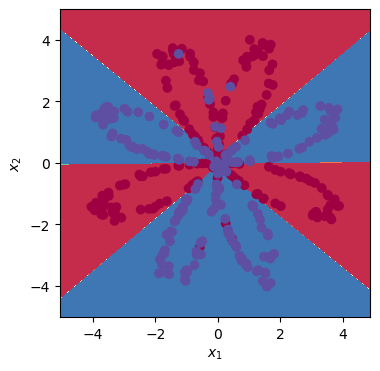

In [26]:
plt.figure(figsize=(4, 4))
plot_decision_boundary(lambda x: predict(x, parameters=parameters), X, y)
y_pred = predict(X, parameters=parameters)
score = np.sum(y == y_pred) / y.shape[0]
print(f"accuracy score: {score}")
print(f" in percentage: {100*score} %")

print(f"W1.shape = {parameters['W1'].shape}")
print(f"b1.shape = {parameters['b1'].shape}")
print(f"W2.shape = {parameters['W2'].shape}")
print(f"b1.shape = {parameters['b2'].shape}")

As we can see, the accuracy significantly improves. The decision boundaries separate the data points adequately. Of course, we don't want to have perfect accuracy score in this case as a perfect score would require a set of extremely complex decision boundaries. Let us try to train the model with the hidden layer of $10$ neurons. We also train with much fewer number of epochs and higher learning rate. As we will see, the accuracy score is very decent.

Loss after epoch 0: 0.82802
Loss after epoch 50: 0.43460
Loss after epoch 100: 0.36105
Loss after epoch 150: 0.32518
Loss after epoch 200: 0.30338
Loss after epoch 250: 0.28851
Loss after epoch 300: 0.27765
Loss after epoch 350: 0.26934
Loss after epoch 400: 0.26275
Loss after epoch 450: 0.25737
Loss after epoch 499: 0.25295
accuracy score: 0.9225
 in percentage: 92.25 %
W1.shape = (10, 2)
b1.shape = (10,)
W2.shape = (1, 10)
b1.shape = (1,)


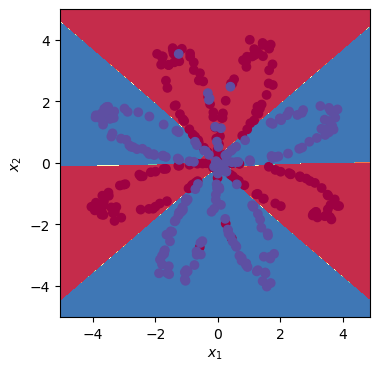

In [27]:
parameters = train_shallow_network(X, y, n_h=10, epochs=500, verbose=True, n_prints=10, lr=0.25)
plt.figure(figsize=(4, 4))
plot_decision_boundary(lambda x: predict(x, parameters=parameters), X, y)

y_pred = predict(X, parameters=parameters)
score = np.sum(y == y_pred) / y.shape[0]
print(f"accuracy score: {score}")
print(f" in percentage: {100*score} %")

print(50*"=")
print(f"W1.shape = {parameters['W1'].shape}")
print(f"b1.shape = {parameters['b1'].shape}")
print(f"W2.shape = {parameters['W2'].shape}")
print(f"b1.shape = {parameters['b2'].shape}")